`April 13, 2022`

## **Time Series Forecasting**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('shampoo_sales.csv')
df.tail()

,Month,Sales
31,3-08,407.6
32,3-09,682.0
33,3-10,475.3
34,3-11,581.3
35,3-12,646.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


In [4]:
df_shampoo = df.copy()
df_shampoo['Month'] = df_shampoo['Month'].apply(lambda x: '200' + x)
df_shampoo['Month'] = pd.to_datetime(df_shampoo['Month'])

In [5]:
df_shampoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 704.0 bytes


In [6]:
df_shampoo.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


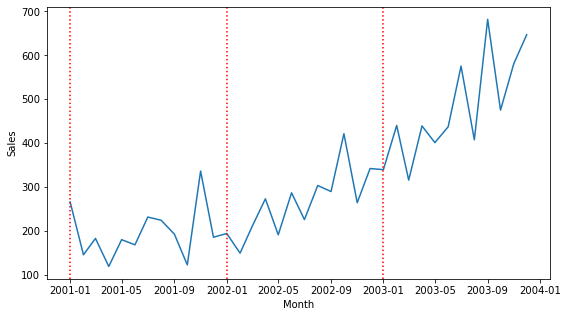

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, ax=ax)
plt.axvline(pd.to_datetime('2001-01-01'), ls=':', color='red')
plt.axvline(pd.to_datetime('2002-01-01'), ls=':', color='red')
plt.axvline(pd.to_datetime('2003-01-01'), ls=':', color='red');

### **Decomposition**

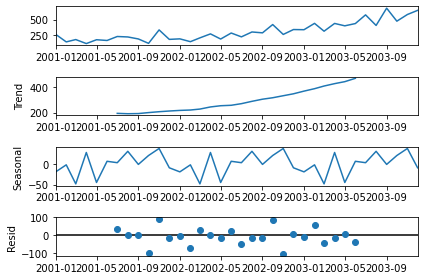

In [8]:
df_shampoo_index = df_shampoo.set_index('Month')
shampoo_decomposition = seasonal_decompose(df_shampoo_index)
shampoo_decomposition.plot();

### **Differencing**

In [9]:
df_shampoo.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


In [10]:
# Differencing level 1 (1st order differencing)
df_shampoo['Sales_Lag1'] = df_shampoo['Sales'].shift(1)
df_shampoo['Sales_Diff1'] = df_shampoo['Sales'] - df_shampoo['Sales_Lag1']

# Differencing level 2 (2nd order differencing)
df_shampoo['Sales_Diff1_Lag1'] = df_shampoo['Sales_Diff1'].shift(1)
df_shampoo['Sales_Diff2'] = df_shampoo['Sales_Diff1'] - df_shampoo['Sales_Diff1_Lag1']
df_shampoo.head()

,Month,Sales,Sales_Lag1,Sales_Diff1,Sales_Diff1_Lag1,Sales_Diff2
0,2001-01-01,266.0,NaN,NaN,NaN,NaN
1,2001-02-01,145.9,266.0,-120.1,NaN,NaN
2,2001-03-01,183.1,145.9,37.2,-120.1,157.3
3,2001-04-01,119.3,183.1,-63.8,37.2,-101.0
4,2001-05-01,180.3,119.3,61.0,-63.8,124.8


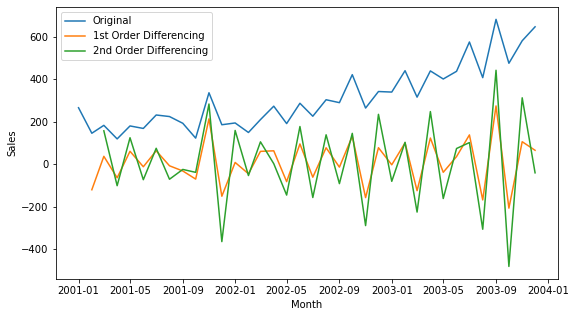

In [11]:
plt.figure(figsize=(9, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, label='Original')
sns.lineplot(x='Month', y='Sales_Diff1', data=df_shampoo, label='1st Order Differencing')
sns.lineplot(x='Month', y='Sales_Diff2', data=df_shampoo, label='2nd Order Differencing');

`Statistical test`

In [12]:
# Statistical test to validate stationarity

# Ho = The data is not stationary
# Ha = The data is stationary

alpha = 0.05
adfuller_pvalue = adfuller(df_shampoo['Sales_Diff1'].dropna())[1]

if adfuller_pvalue <= alpha:
    print('Reject Ho. The data is stationary')
    print(adfuller_pvalue)
else:
    print('Fail to reject Ho. The data is not stationary')
    print(adfuller_pvalue)

Reject Ho. The data is stationary
1.7998574141687034e-10


Conclusion: We only need one time differencing to get our data to be stationary.

### **ACF & PACF Plot**

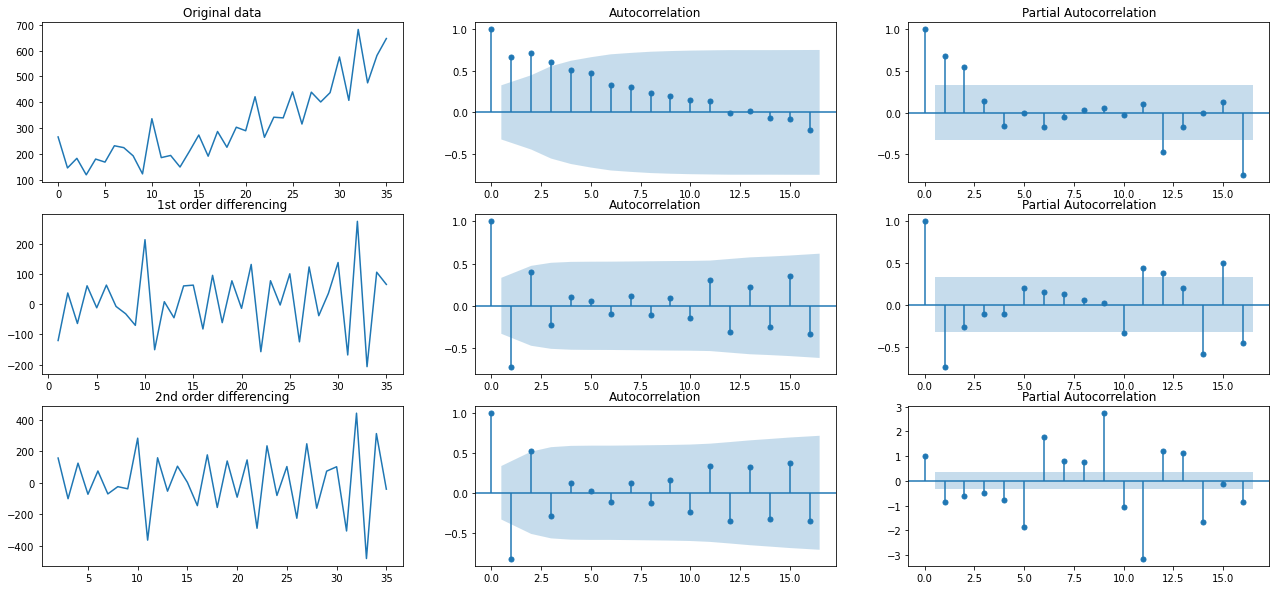

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(22, 10))

# Original data
ax[0, 0].plot(df_shampoo['Sales'])
ax[0, 0].set_title('Original data')
plot_acf(df_shampoo['Sales'], ax=ax[0, 1])
plot_pacf(df_shampoo['Sales'], ax=ax[0, 2])

# 1st order differencing
ax[1, 0].plot(df_shampoo['Sales_Diff1'])
ax[1, 0].set_title('1st order differencing')
plot_acf(df_shampoo['Sales_Diff1'].dropna(), ax=ax[1, 1])
plot_pacf(df_shampoo['Sales_Diff1'].dropna(), ax=ax[1, 2])

# 2nd order differencing
ax[2, 0].plot(df_shampoo['Sales_Diff2'])
ax[2, 0].set_title('2nd order differencing')
plot_acf(df_shampoo['Sales_Diff2'].dropna(), ax=ax[2, 1])
plot_pacf(df_shampoo['Sales_Diff2'].dropna(), ax=ax[2, 2]);

    p: 1
    d: 1
    q: 1

    ARIMA (1, 1, 0) atau ARIMA(0, 1, 1)

### **ARIMA model**

In [14]:
df_shampoo_index.head()

,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


`Modeling`

In [15]:
arima = ARIMA(endog=df_shampoo_index, order=(1, 1, 0))
arima_fit = arima.fit()

In [16]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -201.287
Date:                Thu, 14 Apr 2022   AIC                            406.575
Time:                        09:23:06   BIC                            409.686
Sample:                    01-01-2001   HQIC                           407.649
                         - 12-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7142      0.136     -5.259      0.000      -0.980      -0.448
sigma2      5683.4514   1448.557      3.924      0.000    2844.331    8522.572
Ljung-Box (L1) (Q):                   1.89   Jarque-

In [17]:
arima_fit.fittedvalues

Month
2001-01-01      0.000000
2001-02-01    263.821085
2001-03-01    231.679270
2001-04-01    156.530568
2001-05-01    164.868005
2001-06-01    136.731845
2001-07-01    176.927938
2001-08-01    186.589111
2001-09-01    229.713894
2001-10-01    215.441156
2001-11-01    172.824821
2001-12-01    183.940033
2002-01-01    293.463347
2002-02-01    188.300451
2002-03-01    181.497596
2002-04-01    166.817538
2002-05-01    228.160534
2002-06-01    249.895605
2002-07-01    218.719416
2002-08-01    269.568155
2002-09-01    248.175593
2002-10-01    299.684979
2002-11-01    327.535639
2002-12-01    376.705856
2003-01-01    286.732746
2003-02-01    341.557003
2003-03-01    368.476832
2003-04-01    404.821891
2003-05-01    351.163765
2003-06-01    428.440818
2003-07-01    411.616223
2003-08-01    476.864553
2003-09-01    527.519562
2003-10-01    486.014725
2003-11-01    622.931765
2003-12-01    505.591402
dtype: float64

In [18]:
df_shampoo['Sales_Predicted'] = arima_fit.fittedvalues.values
df_shampoo.head()

,Month,Sales,Sales_Lag1,Sales_Diff1,Sales_Diff1_Lag1,Sales_Diff2,Sales_Predicted
0,2001-01-01,266.0,NaN,NaN,NaN,NaN,0.000000
1,2001-02-01,145.9,266.0,-120.1,NaN,NaN,263.821085
2,2001-03-01,183.1,145.9,37.2,-120.1,157.3,231.679270
3,2001-04-01,119.3,183.1,-63.8,37.2,-101.0,156.530568
4,2001-05-01,180.3,119.3,61.0,-63.8,124.8,164.868005


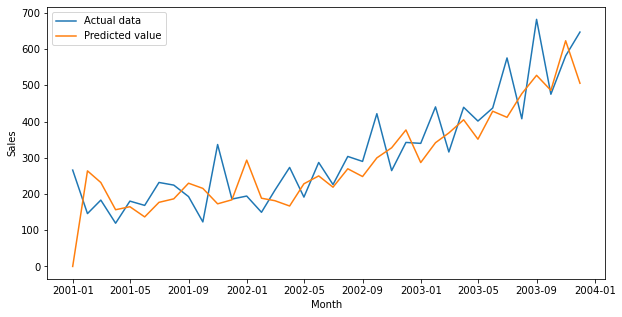

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, label='Actual data')
sns.lineplot(x='Month', y='Sales_Predicted', data=df_shampoo, label='Predicted value');

`Forecasting`

In [20]:
forecast_one_year = arima_fit.forecast(6)
forecast_one_year

2004-01-01    600.046377
2004-02-01    633.510736
2004-03-01    609.609419
2004-04-01    626.680506
2004-05-01    614.487788
2004-06-01    623.196218
Freq: MS, Name: predicted_mean, dtype: float64

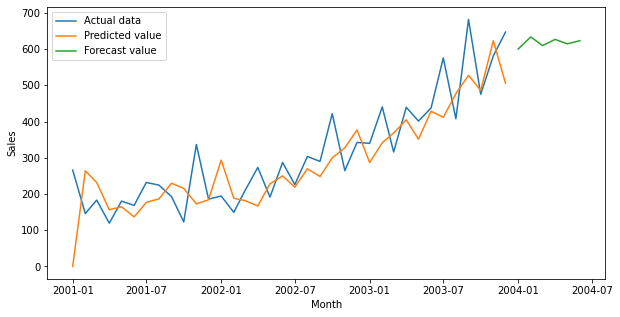

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Sales', data=df_shampoo, label='Actual data')
sns.lineplot(x='Month', y='Sales_Predicted', data=df_shampoo, label='Predicted value')
sns.lineplot(x=forecast_one_year.index, y=forecast_one_year.values, label='Forecast value');

### **Time Series with Exogenus Variable**

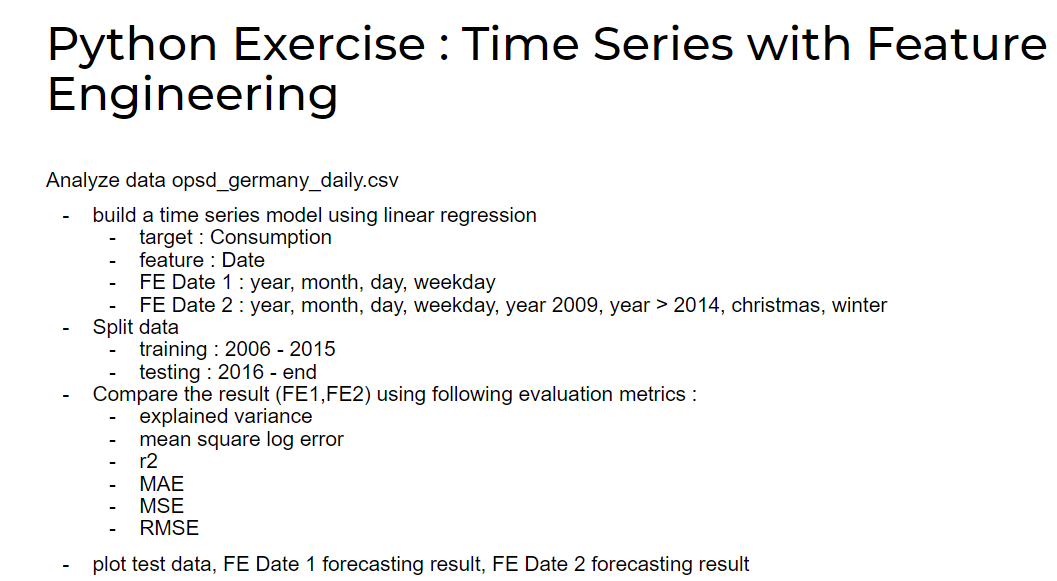

In [22]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

In [23]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url,sep=",")

In [24]:
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [25]:
df.isnull().sum()

Date              0
Consumption       0
Wind           1463
Solar          2195
Wind+Solar     2196
dtype: int64

> ## Date Feature Engineering

In [26]:
df['Date'] = pd.to_datetime(df['Date'])

In [27]:
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [28]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.weekday

In [29]:
df[['Date','year','month','day','weekday']]

,Date,year,month,day,weekday
0,2006-01-01,2006,1,1,6
1,2006-01-02,2006,1,2,0
2,2006-01-03,2006,1,3,1
3,2006-01-04,2006,1,4,2
4,2006-01-05,2006,1,5,3
...,...,...,...,...,...
4378,2017-12-27,2017,12,27,2
4379,2017-12-28,2017,12,28,3
4380,2017-12-29,2017,12,29,4
4381,2017-12-30,2017,12,30,5


In [30]:
cat_features = ['month','day','weekday']

transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),cat_features)],
                                 remainder = 'passthrough'
                                )

> ## EDA

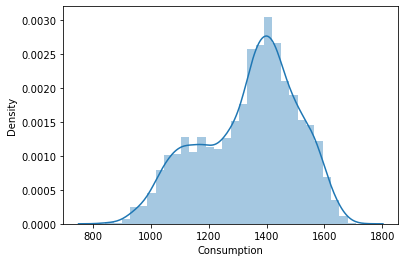

In [34]:
sns.distplot(df["Consumption"]);

In [35]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name = 'true',x=df['Date'], y=df['Consumption'])])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
df[~df['Wind'].isnull()]

,Date,Consumption,Wind,Solar,Wind+Solar,year,month,day,weekday
1461,2010-01-01,1057.37200,48.709,NaN,NaN,2010,1,1,4
1462,2010-01-02,1161.04200,24.628,NaN,NaN,2010,1,2,5
1463,2010-01-03,1132.06900,22.963,NaN,NaN,2010,1,3,6
1464,2010-01-04,1346.25000,59.318,NaN,NaN,2010,1,4,0
1465,2010-01-05,1457.37400,41.624,NaN,NaN,2010,1,5,1
...,...,...,...,...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037,2017,12,27,2
4379,2017-12-28,1299.86398,506.424,14.162,520.586,2017,12,28,3
4380,2017-12-29,1295.08753,584.277,29.854,614.131,2017,12,29,4
4381,2017-12-30,1215.44897,721.247,7.467,728.714,2017,12,30,5


In [ ]:
df[~df['Solar'].isnull()]

,Date,Consumption,Wind,Solar,Wind+Solar,year,month,day,weekday
2191,2012-01-01,948.12800,227.465,6.587,234.052,2012,1,1,6
2192,2012-01-02,1269.58100,207.327,6.574,213.901,2012,1,2,0
2193,2012-01-03,1334.74500,473.468,24.679,498.147,2012,1,3,1
2194,2012-01-04,1347.13600,499.804,14.681,514.485,2012,1,4,2
2195,2012-01-05,1376.65800,523.851,5.071,528.922,2012,1,5,3
...,...,...,...,...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037,2017,12,27,2
4379,2017-12-28,1299.86398,506.424,14.162,520.586,2017,12,28,3
4380,2017-12-29,1295.08753,584.277,29.854,614.131,2017,12,29,4
4381,2017-12-30,1215.44897,721.247,7.467,728.714,2017,12,30,5


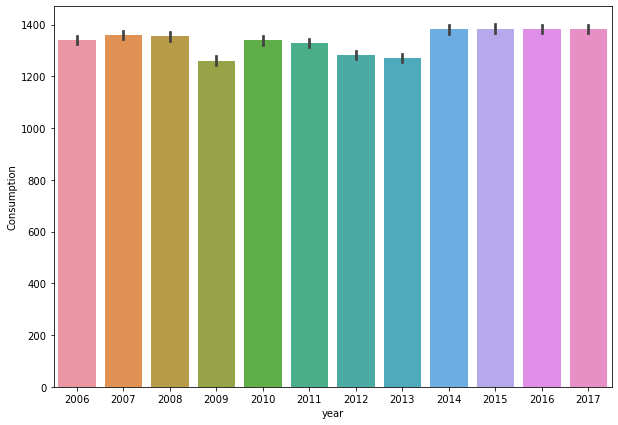

In [36]:
plt.figure(figsize=(10,7))
sns.barplot(x = 'year', y = 'Consumption', data = df);

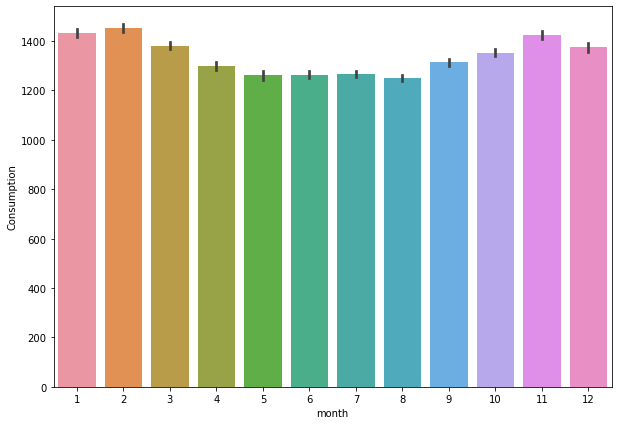

In [37]:
plt.figure(figsize=(10,7))
sns.barplot(x = 'month', y = 'Consumption', data = df);

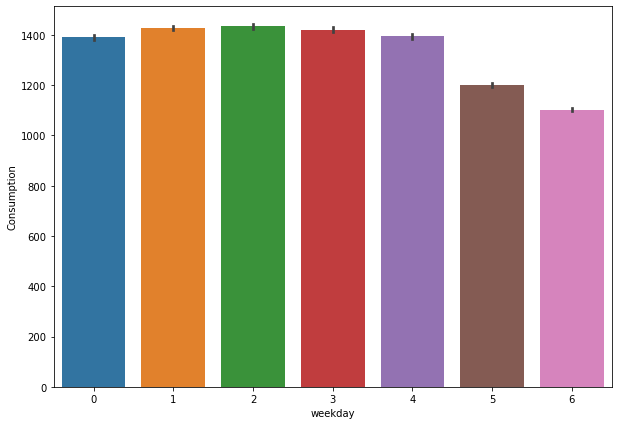

In [38]:
plt.figure(figsize=(10,7))
sns.barplot(x = 'weekday', y = 'Consumption', data = df);

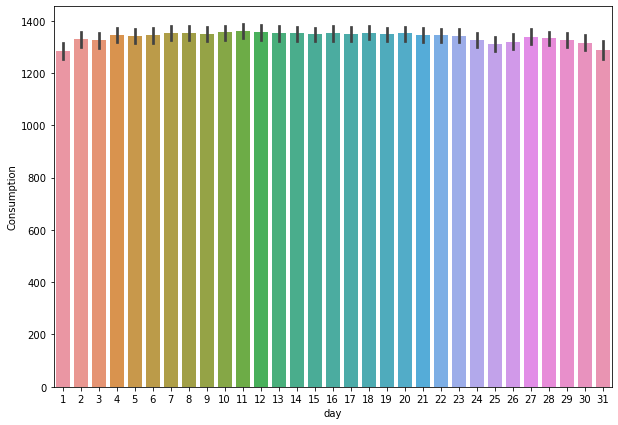

In [39]:
plt.figure(figsize=(10,7))
sns.barplot(x = 'day', y = 'Consumption', data = df);

### **Model Benchmark**

Data Splitting

In [40]:
df_train = df[df['year'] < 2016 ] 
X_train = df_train[['year','month','day','weekday']]
y_train = df_train['Consumption']

df_test = df[df['year'] >= 2016 ]
X_test = df_test[['year','month','day','weekday']]
y_test = df_test['Consumption']

In [41]:
transformer.fit(X_train)
X_train_preprocessed = transformer.transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

In [42]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))\

    sns.scatterplot(y_pred,y_true-y_pred)

In [43]:
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)
y_pred_train = model.predict(X_train_preprocessed)
y_pred = model.predict(X_test_preprocessed)

explained_variance:  0.7287
mean_squared_log_error:  0.0046
r2:  0.7287
MAE:  61.954
MSE:  7394.1808
RMSE:  85.9894


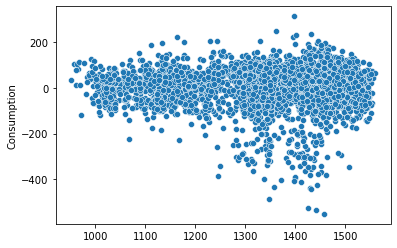

In [44]:
regression_results(y_train, y_pred_train)

explained_variance:  0.8069
mean_squared_log_error:  0.0039
r2:  0.7239
MAE:  66.0505
MSE:  7245.0027
RMSE:  85.1176


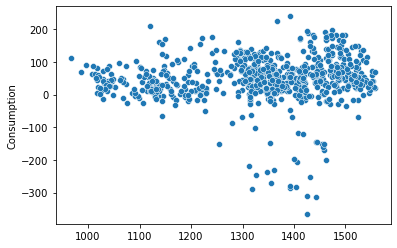

In [45]:
regression_results(y_test, y_pred)

In [46]:
df_test['y_pred'] = y_pred

In [47]:
fig = go.Figure([go.Scatter(name = 'true',x=df_test['Date'], y=df_test['Consumption'])])
fig.add_trace(go.Scatter(name = 'prediction',x=df_test['Date'], y=df_test['y_pred']))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

> ## More Feature Engineering

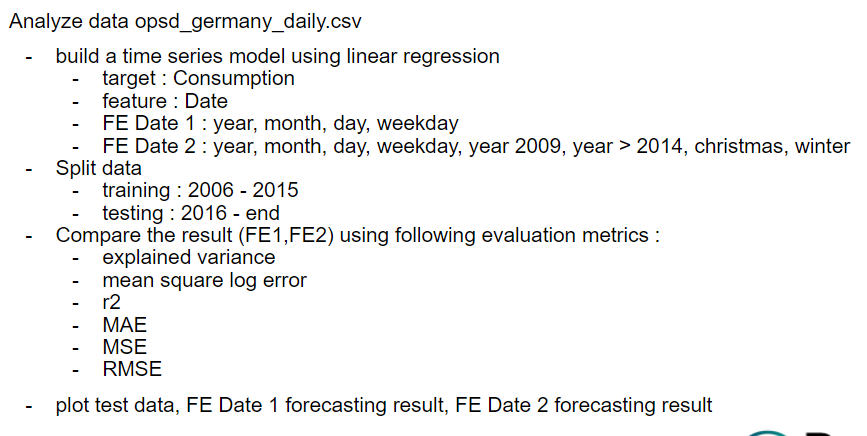

In [48]:
df

,Date,Consumption,Wind,Solar,Wind+Solar,year,month,day,weekday
0,2006-01-01,1069.18400,NaN,NaN,NaN,2006,1,1,6
1,2006-01-02,1380.52100,NaN,NaN,NaN,2006,1,2,0
2,2006-01-03,1442.53300,NaN,NaN,NaN,2006,1,3,1
3,2006-01-04,1457.21700,NaN,NaN,NaN,2006,1,4,2
4,2006-01-05,1477.13100,NaN,NaN,NaN,2006,1,5,3
...,...,...,...,...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037,2017,12,27,2
4379,2017-12-28,1299.86398,506.424,14.162,520.586,2017,12,28,3
4380,2017-12-29,1295.08753,584.277,29.854,614.131,2017,12,29,4
4381,2017-12-30,1215.44897,721.247,7.467,728.714,2017,12,30,5


In [49]:
# Feature engineering
df['2009'] = np.where(df['year'] == 2009,1,0)
df['>2014'] = np.where(df['year'] > 2014,1,0)

christmas = (df['month'] == 12) & ((df['day'] >= 25) & (df['day'] <= 31)) | (df['month'] == 1) & ((df['day'] >= 1) & (df['day'] <= 7))
df['christmas'] = np.where(christmas,1,0)

winter = df['month'].isin([12,1,2,3])
df['winter'] = np.where(winter,1,0)

In [50]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar,year,month,day,weekday,2009,>2014,christmas,winter
0,2006-01-01,1069.184,NaN,NaN,NaN,2006,1,1,6,0,0,1,1
1,2006-01-02,1380.521,NaN,NaN,NaN,2006,1,2,0,0,0,1,1
2,2006-01-03,1442.533,NaN,NaN,NaN,2006,1,3,1,0,0,1,1
3,2006-01-04,1457.217,NaN,NaN,NaN,2006,1,4,2,0,0,1,1
4,2006-01-05,1477.131,NaN,NaN,NaN,2006,1,5,3,0,0,1,1


In [51]:
df_train = df[df['year'] < 2016 ] 
X_train = df_train[['year','month','day','weekday','2009','>2014','christmas','winter']]
y_train = df_train['Consumption']

df_test = df[df['year'] >= 2016 ]
X_test = df_test[['year','month','day','weekday','2009','>2014','christmas','winter']]
y_test = df_test['Consumption']

In [52]:
transformer.fit(X_train)
X_train_preprocessed = transformer.transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

In [53]:
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)
y_pred_train = model.predict(X_train_preprocessed)
y_pred_2 = model.predict(X_test_preprocessed)

explained_variance:  0.81
mean_squared_log_error:  0.0033
r2:  0.81
MAE:  49.6287
MSE:  5179.4544
RMSE:  71.9684


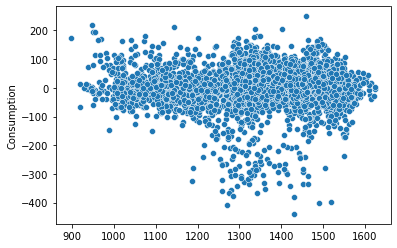

In [54]:
regression_results(y_train, y_pred_train)

explained_variance:  0.8527
mean_squared_log_error:  0.0022
r2:  0.8516
MAE:  41.576
MSE:  3893.864
RMSE:  62.4008


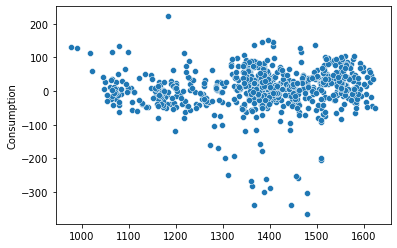

In [55]:
regression_results(y_test, y_pred_2)

> ### Before After

BEFORE

explained_variance:  0.8069
mean_squared_log_error:  0.0039
r2:  0.7239
MAE:  66.0505
MSE:  7245.0027
RMSE:  85.1176


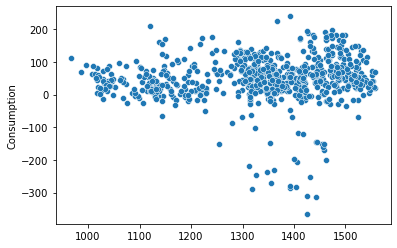

In [56]:
regression_results(y_test, y_pred)

AFTER

explained_variance:  0.8527
mean_squared_log_error:  0.0022
r2:  0.8516
MAE:  41.576
MSE:  3893.864
RMSE:  62.4008


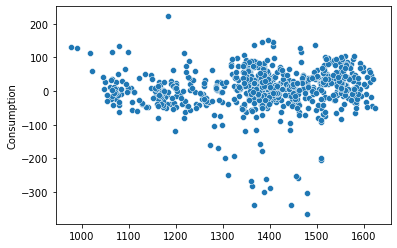

In [57]:
regression_results(y_test, y_pred_2)

In [58]:
df_test['y_pred'] = y_pred

In [59]:
df_test['y_pred_2'] = y_pred_2

In [60]:
fig = go.Figure([go.Scatter(name = 'true value',x=df_test['Date'], y=df_test['Consumption'])])
fig.add_trace(go.Scatter(name = 'forecast FE Date 1',x=df_test['Date'], y=df_test['y_pred']))
fig.add_trace(go.Scatter(name = 'forecast FE Date 2',x=df_test['Date'], y=df_test['y_pred_2']))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### **Python Exercise: Time Series Evaluation**


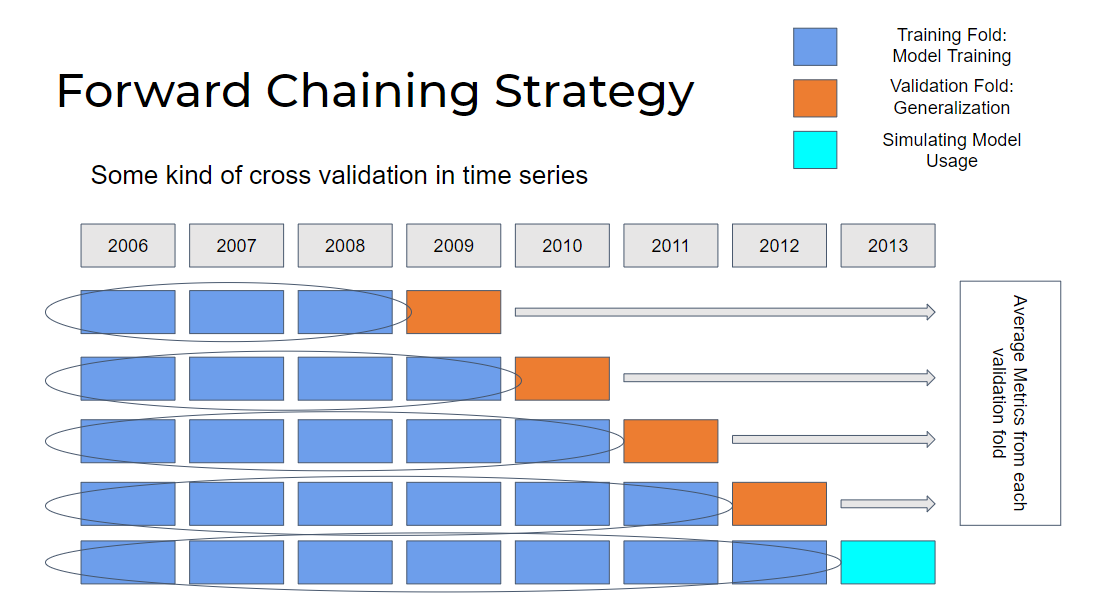

Models we will try:
1. linear regression
1. ridge regression
1. lasso regression
1. elastic net
1. SVR

In [61]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

Ridge: 0.688664 (0.124313)
Lasso: 0.689898 (0.121739)
E-Net: 0.218973 (0.097753)
SVR: -0.019511 (0.059007)
KNN: 0.553557 (0.061469)


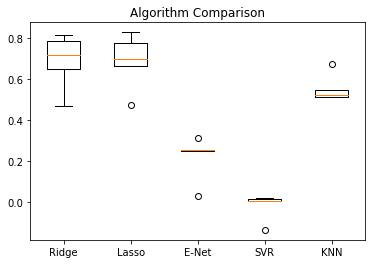

In [62]:
models = []
models.append(('Ridge', Ridge())) 
models.append(('Lasso', Lasso()))
models.append(('E-Net', ElasticNet()))
models.append(('SVR', SVR(gamma='auto')))
models.append(('KNN', KNeighborsRegressor())) 

# Evaluate each model in turn
results = []
names = []
for name, model in models:
  # TimeSeries Cross validation
  tscv = TimeSeriesSplit(n_splits=5)
    
  cv_results = cross_val_score(model, X_train_preprocessed, y_train, cv=tscv, scoring='r2')
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

### **Hyperparameter Tuning**

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [64]:
model = Ridge()
pipe_model = Pipeline([
                       ('preprocess',transformer),
                       ('model',model)
])

param_search = {
    'model__alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001]
}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(
    estimator = pipe_model,
    cv = tscv,
    param_grid = param_search,
    scoring = 'r2'
)

In [65]:
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_parameter = gsearch.best_params_
best_model = gsearch.best_estimator_

In [66]:
print('best score',best_score)
print('best_parameter',best_parameter)
print('best model',best_model)

best score 0.6886642202029931
best_parameter {'model__alpha': 1}
best model Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['month', 'day',
                                                   'weekday'])])),
                ('model', Ridge(alpha=1))])


In [67]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['month', 'day',
                                                   'weekday'])])),
                ('model', Ridge(alpha=1))])

In [68]:
y_pred_3 = best_model.predict(X_test)

explained_variance:  0.8527
mean_squared_log_error:  0.0022
r2:  0.8515
MAE:  41.5988
MSE:  3895.8926
RMSE:  62.4171


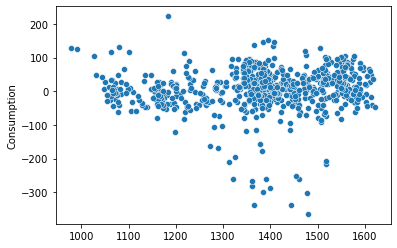

In [69]:
regression_results(y_test, y_pred_3)

In [70]:
df_test['y_pred_3'] = y_pred_3

In [73]:
fig = go.Figure([go.Scatter(name = 'true value',x=df_test['Date'], y=df_test['Consumption'])])
fig.add_trace(go.Scatter(name = 'forecast FE Date 1',x=df_test['Date'], y=df_test['y_pred']))
fig.add_trace(go.Scatter(name = 'forecast FE Date 2',x=df_test['Date'], y=df_test['y_pred_2']))
fig.add_trace(go.Scatter(name = 'forecast FE Date 2 Tuned Model',x=df_test['Date'], y=df_test['y_pred_3']))
fig.update_xaxes(rangeslider_visible=True)
fig.show()